# Checking the preprocessed data
In this notebook, we'll analyze the preprocessed datasets to check their quality.

# Imports and paths

In [1]:
%cd ..

/home/cdauvill/inria/multi_sources


In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import yaml
from netCDF4 import Dataset
from pathlib import Path
from multi_sources.data_processing.multi_source_dataset import MultiSourceDataset
from multi_sources.data_processing.utils import read_sources

In [3]:
with open("conf/paths/paths.yaml", "r") as f:
    paths = yaml.safe_load(f)
with open("conf/sources/all_microwave.yaml", "r") as f:
    sources_cfg = yaml.safe_load(f)

# Building the dataset
We'll use the ```MultiSourceDataset```, which is a map-style torch ```Dataset``` custom subclass.

In [4]:
# Create the dataset
metadata_path = paths['metadata']
dataset_dir = paths['preprocessed_dataset']
sources = read_sources(sources_cfg)
dataset = MultiSourceDataset(metadata_path, dataset_dir, sources,
                             include_seasons=[2016])

In [5]:
len(dataset)

2343

# Displaying a single sample
We'll first have a look at a single sample yielded by the dataset.

In [6]:
rng = np.random.default_rng(42)
sample = dataset[rng.integers(low=0, high=len(dataset), size=1)[0]]
# sample is a dict {source_name: (S, DT, C, D, V)}

## Composition
Let's check which sources are available. A source is unavailable if ```ÐT, C, D,``` and ```V``` are filled with ```NaN```.

In [7]:
def available_sources(sample):
    return [sn for sn, (_, dt, _, _, _) in sample.items() if ~(dt.isnan()).item()]
print("Available sources:")
for sn in available_sources(sample):
    print(sn)

Available sources:
tc_primed.microwave.AMSR2_GCOMW1.S1
tc_primed.microwave.AMSR2_GCOMW1.S2
tc_primed.microwave.AMSR2_GCOMW1.S3
tc_primed.microwave.AMSR2_GCOMW1.S4
tc_primed.microwave.AMSR2_GCOMW1.S5
tc_primed.microwave.AMSR2_GCOMW1.S6
tc_primed.microwave.ATMS_NPP.S1
tc_primed.microwave.ATMS_NPP.S2
tc_primed.microwave.ATMS_NPP.S3
tc_primed.microwave.ATMS_NPP.S4
tc_primed.microwave.GMI_GPM.S1
tc_primed.microwave.GMI_GPM.S2
tc_primed.microwave.MHS_METOPA.S1
tc_primed.microwave.MHS_METOPB.S1
tc_primed.microwave.MHS_NOAA18.S1
tc_primed.microwave.MHS_NOAA19.S1
tc_primed.microwave.ATMS_NOAA20.S1
tc_primed.microwave.SSMIS_F16.S1
tc_primed.microwave.SSMIS_F16.S2
tc_primed.microwave.SSMIS_F16.S3
tc_primed.microwave.ATMS_NOAA20.S2
tc_primed.microwave.SSMIS_F16.S4
tc_primed.microwave.SSMIS_F17.S1
tc_primed.microwave.SSMIS_F17.S2
tc_primed.microwave.ATMS_NOAA20.S3
tc_primed.microwave.SSMIS_F17.S3
tc_primed.microwave.SSMIS_F17.S4
tc_primed.microwave.SSMIS_F18.S1
tc_primed.microwave.SSMIS_F18.S2
tc_p

## Coordinates and land mask
Let's select the source ```AMSR_GCOMW1.S1``` as it is very frequently available (see ```notebooks/sources.ipynb```).

In [8]:
s, dt, c, d, v = sample['tc_primed.microwave.AMSR2_GCOMW1.S1']

The first two context variables are the latitude and longitude:

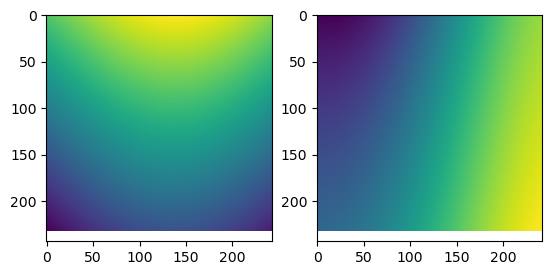

In [9]:
lat, lon = c[0], c[1]
plt.subplot(121)
plt.imshow(lat)
plt.subplot(122)
plt.imshow(lon)

Note that for the context and value variables, the images are NaN-padded at the border (as they don't have the same size across samples originally).

The third context variable is the land-sea mask:

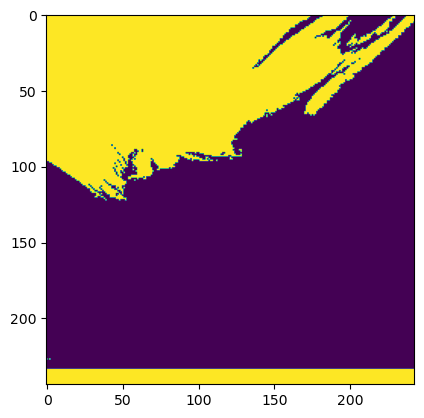

In [10]:
plt.imshow(c[2])

## Values
Let's now look at the values (i.e. the observation themselves).

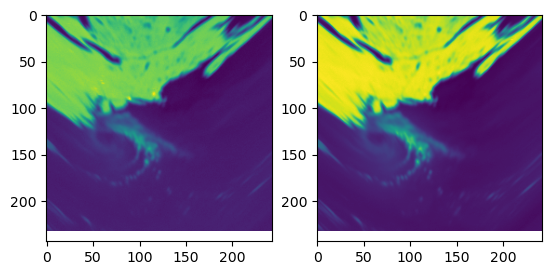

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=v.shape[0])
for i in range(v.shape[0]):
    axes[i].imshow(v[i])